# TFM. Deep Visin applied to Real state.


In [3]:
# google stuff
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [4]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


- libraries

In [5]:
%tensorflow_version 2.x
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import tensorflow as tf
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# architecture 
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import Model

# metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


# optimization
from tensorflow.keras.optimizers import Adam
from keras import regularizers
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, BatchNormalization, MaxPooling2D, Flatten, ZeroPadding2D
from tensorflow.keras.regularizers import l1_l2, l2

# pre-trained models
from tensorflow.keras.applications import VGG16, ResNet50, VGG19

import os
import pickle
import tarfile

# counting classes with library
from collections import Counter

# viz & arrays
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

- base directory

In [6]:
!ls "/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/"

 AlbertoVargas-sistema_clasificacion_viviendas_imagenes.gslides   input    src
'Dudas y seguimiento TFM.gdoc'					  output


In [7]:
base_folder = "/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/"
input_folder = base_folder+"input/"
src_folder =  base_folder+"src/"
output_folder = base_folder + "/output/"

- functions

In [8]:
# insert the directory
import sys
sys.path.insert(0,"/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/src/")

In [9]:
from my_functions import freezing_layers

# load pickling data allocated in Drive

In [10]:
with open(input_folder+"pickle_all_images_df.pickle", "rb") as input_file:
    data_x = pickle.load(input_file)
with open(input_folder+"pickle_all_classes.pickle", "rb") as input_file:
    data_y = pickle.load(input_file)

- some preview

In [11]:
print(Counter(data_y))

Counter({'Livingroom': 1273, 'Bedroom': 1248, 'Dinning': 1158, 'Kitchen': 965, 'Bathroom': 606})


In [12]:
classes_list = list(Counter(data_y).keys())

- i'll have to deal with this unbalanced classes later. 
- let's begin with the simplest stuff first

In [13]:
print("pics shape: ",data_x.shape,
      "\nnumber of classes: ", len(set(data_y))
      )

pics shape:  (5250, 128, 128, 3) 
number of classes:  5


Dinning


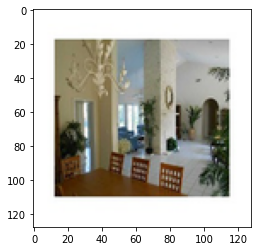

In [14]:
# # showing some stuff 
print(data_y[42])
imgplot = plt.imshow(data_x[42])
plt.show()

- transforming y-label into numeric

In [15]:
# transforming labels into numeric
y = np.unique(data_y)
mapping = { key : value for key,value in zip(y,range(len(y)))}
data_y_num = np.array([mapping[i] for i in data_y])

In [16]:
test_size_1st_split = 0.3
test_size_2nd_split= 0.5

x_train, x_test, y_train, y_test = train_test_split(data_x, data_y_num, test_size=test_size_1st_split)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_size_2nd_split) 
allx= len(data_x)
print(round(len(x_train)/allx,2), round(len(x_val)/allx,2), round(len(x_test)/allx,2))
del data_y
del data_x

#One-hot encoding
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)
y_val = lb.transform(y_val)

0.7 0.15 0.15


In [17]:
print("train:  ", x_train.shape, y_train.shape,
      "\ntest: ", x_test.shape,y_test.shape,
      "\nval:  ", x_val.shape, y_val.shape)

train:   (3675, 128, 128, 3) (3675, 5) 
test:  (788, 128, 128, 3) (788, 5) 
val:   (787, 128, 128, 3) (787, 5)


In [18]:
#Data Augmentation first
train_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True, zoom_range=.1)
val_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True, zoom_range=.1)
test_generator = ImageDataGenerator(rotation_range=2, horizontal_flip= True, zoom_range=.1)

#Fitting the augmentation defined above to the data
train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(x_test)

## VGG16

let's 
- remove the last layer and change it by a final layer with 5 neurons for our 5 classes (this is done loading all but last layer).
- freeze layers

In [23]:
# https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16
base_model_vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = y_train.shape[1], classifier_activation='softmax')
pre_trained_vgg16 = Sequential() # to add more stuff

for layer in base_model_vgg16.layers[:-1]: # not loading the last layer
    pre_trained_vgg16.add(layer)    

pre_trained_vgg16.add(Flatten()) # before the final layer has the shape (None, 8, 8, 5). I do need (0, 5)

# Freeze the layers 
for layer in pre_trained_vgg16.layers:
    layer.trainable = False

# Add 'softmax' instead of earlier 'prediction' layer.
pre_trained_vgg16.add(Dense(4096,activation=('relu')))
pre_trained_vgg16.add(Dense(4096,activation=('relu'))) 
pre_trained_vgg16.add(Dense(5,activation=('softmax'))) 
pre_trained_vgg16.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
_______________________________________________________

- training

In [24]:
#Learning Rate Annealer - decreases the learning rate after a certain number of epochs if the error rate does not change. Here, through this technique, 
# we will monitor the validation accuracy and if it seems to be a plateau in 3 epochs, it will reduce the learning rate by 0.01.
from keras.callbacks import ReduceLROnPlateau

lrr= ReduceLROnPlateau(monitor='accuracy', factor=.001, patience=3, min_lr=1e-4) # "val_acc " warning

In [27]:
#Initializing the hyperparameters
from tensorflow.keras.optimizers import SGD, Adam
batch_size= 128
epochs=200
learn_rate=.01
sgd=SGD(learning_rate=learn_rate,momentum=.9,nesterov=False)
adam=Adam(learning_rate=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# crossentroty: logaritmic metric from 0.99 (terrible) to 0 (too much perfect)=> https://machinelearningmastery.com/loss-and-loss-functions-for-training-deep-learning-neural-networks/
pre_trained_vgg16.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'] ) # quizás no haga falta para que te valsa validation accuracy

In [28]:
#Training the model - al usar esta config no tengo un array de val_accuracy, val_loss https://stackoverflow.com/questions/55746382/why-val-loss-and-val-acc-are-not-displaying

model_vgg16= pre_trained_vgg16.fit_generator(
    train_generator.flow(x_train, y_train, batch_size= batch_size),
    epochs = epochs, 
    validation_data = val_generator.flow(x_val, y_val, batch_size = batch_size), 
    steps_per_epoch = len(x_train)//batch_size , # to avoid running out of data error
    validation_steps  = len(x_test)//batch_size, # to avoid running out of data error
    callbacks=[lrr], # añadir early stopping
    verbose = 1
    )

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
28/28 [==============================] - 71s 1s/step - loss: 433.8241 - accuracy: 0.2120 - val_loss: 1.8561 - val_accuracy: 0.2227
Epoch 2/200
28/28 [==============================] - 21s 749ms/step - loss: 1.8778 - accuracy: 0.2862 - val_loss: 1.8643 - val_accuracy: 0.3242
Epoch 3/200
28/28 [==============================] - 21s 744ms/step - loss: 1.8200 - accuracy: 0.2890 - val_loss: 2.0229 - val_accuracy: 0.2552
Epoch 4/200
28/28 [==============================] - 21s 740ms/step - loss: 1.7334 - accuracy: 0.2695 - val_loss: 1.4805 - val_accuracy: 0.3372
Epoch 5/200
28/28 [==============================] - 21s 749ms/step - loss: 1.4787 - accuracy: 0.3905 - val_loss: 1.3519 - val_accuracy: 0.4049
Epoch 6/200
28/28 [==============================] - 21s 742ms/step - loss: 1.2407 - accuracy: 0.4725 - val_loss: 1.2899 - val_accuracy: 0.4440
Epoch 7/200
28/28 [==============================] - 21s 739ms/step - loss: 1.1310 - accuracy: 0.5224 - val_loss: 1.2368 - val_accuracy: 

In [ ]:
#save model (before fit_generator)
pre_trained_vgg16.save(output_folder+"20211010-vgg16_1.h5")

Text(0, 0.5, 'Loss/Accuracy')

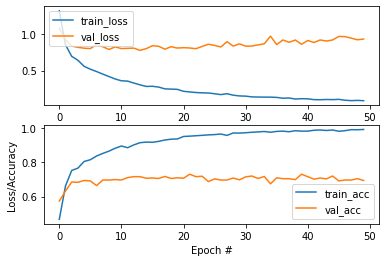

In [ ]:
#Plotting the training and validation loss and accuracy
f,ax=plt.subplots(2,1) 

#Loss
ax[0].plot(np.arange(0, epochs), model_vgg16.history["loss"], label="train_loss")
ax[0].plot(np.arange(0, epochs), model_vgg16.history["val_loss"], label="val_loss")
ax[0].legend()
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
#Accuracy
ax[1].plot(np.arange(0, epochs), model_vgg16.history["accuracy"], label="train_acc")
ax[1].plot(np.arange(0, epochs), model_vgg16.history["val_accuracy"], label="val_acc")
ax[1].legend()
#plt.legend()
#plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")

In [ ]:
#Evaluatin
print("[INFO]: Model godness...")
y_pred = pre_trained_vgg16.predict(x_test, batch_size=128)
y_true=np.argmax(y_test,axis=1)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names = classes_list ))

[INFO]: Model godness...
              precision    recall  f1-score   support

     Dinning       0.74      0.65      0.69        97
     Bedroom       0.73      0.76      0.75       175
  Livingroom       0.69      0.68      0.69       171
     Kitchen       0.62      0.78      0.69       143
    Bathroom       0.66      0.56      0.60       202

    accuracy                           0.68       788
   macro avg       0.69      0.69      0.68       788
weighted avg       0.69      0.68      0.68       788



------------------------------------

## resnet50

let's 
- remove the last layer and change it by a final layer with 5 neurons for our 5 classes (this is done loading all but last layer).
- freeze layers

Estaba teniendo problemas con establecer Sequential() con la resnet. antes lo hacía como la primera celda muteada y daba error. abajo me sale bien, no entiendo muy bien por qué todavía

In [ ]:
#base_model_resnet50.summary()

In [ ]:
# #https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50
# base_model_resnet50= ResNet50(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = y_train.shape[1], classifier_activation='softmax')
# pre_trained_resnet50 = Sequential() # to add more stuff

# for layer in base_model_resnet50.layers[:-1]: # not loading the last layer
#     pre_trained_resnet50.add(layer)    

# pre_trained_resnet50.add(Flatten()) # before the final layer has the shape (None, 8, 8, 5). I do need (0, 5)

# # Freeze the layers 
# for layer in pre_trained_resnet50.layers:
#     layer.trainable = False

# # Add 'softmax' instead of earlier 'prediction' layer.
# pre_trained_resnet50.add(Dense(5,activation=('softmax'))) 
# pre_trained_resnet50.summary()

In [ ]:
pre_trained_resnet50 = Sequential()
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
pre_trained_resnet50.add(ResNet50(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = y_train.shape[1], classifier_activation='softmax'))
pre_trained_resnet50.add(Flatten()) # before the final layer has the shape (None, 4, 4, 5). I do need (0, 5)
pre_trained_resnet50.add(Dense(5,activation=('softmax'))) 

# Say not to train first layer (ResNet) model as it is already trained
pre_trained_resnet50.layers[0].trainable = False

In [ ]:
pre_trained_resnet50.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 163845    
Total params: 23,751,557
Trainable params: 163,845
Non-trainable params: 23,587,712
_________________________________________________________________


- training

In [ ]:
#Learning Rate Annealer - decreases the learning rate after a certain number of epochs if the error rate does not change. Here, through this technique, 
# we will monitor the validation accuracy and if it seems to be a plateau in 3 epochs, it will reduce the learning rate by 0.01.
from keras.callbacks import ReduceLROnPlateau

lrr= ReduceLROnPlateau(monitor='accuracy', factor=.01, patience=3, min_lr=1e-5) # "val_acc " warning

In [ ]:
#Initializing the hyperparameters
from tensorflow.keras.optimizers import SGD, Adam
batch_size= 128
epochs=50
learn_rate=.001
sgd=SGD(learning_rate=learn_rate,momentum=.9,nesterov=False)
adam=Adam(learning_rate=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# crossentroty: logaritmic metric from 0.99 (terrible) to 0 (too much perfect)=> https://machinelearningmastery.com/loss-and-loss-functions-for-training-deep-learning-neural-networks/
pre_trained_resnet50.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
#Training the model - al usar esta config no tengo un array de val_accuracy, val_loss https://stackoverflow.com/questions/55746382/why-val-loss-and-val-acc-are-not-displaying

model_resnet50= pre_trained_resnet50.fit_generator(
    train_generator.flow(x_train, y_train, batch_size= batch_size),
    epochs = epochs, 
    validation_data = val_generator.flow(x_val, y_val, batch_size = batch_size), 
    steps_per_epoch = len(x_train)//batch_size , # to avoid running out of data error
    validation_steps  = len(x_test)//batch_size, # to avoid running out of data error
    callbacks=[lrr], 
    verbose = 1
    )

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
28/28 [==============================] - 56s 833ms/step - loss: 1.6210 - accuracy: 0.2467 - val_loss: 1.5597 - val_accuracy: 0.2721
Epoch 2/50
28/28 [==============================] - 19s 691ms/step - loss: 1.5277 - accuracy: 0.2915 - val_loss: 1.5017 - val_accuracy: 0.3255
Epoch 3/50
28/28 [==============================] - 19s 692ms/step - loss: 1.4751 - accuracy: 0.3296 - val_loss: 1.5086 - val_accuracy: 0.2878
Epoch 4/50
28/28 [==============================] - 19s 692ms/step - loss: 1.4889 - accuracy: 0.3327 - val_loss: 1.4957 - val_accuracy: 0.3320
Epoch 5/50
28/28 [==============================] - 19s 691ms/step - loss: 1.4350 - accuracy: 0.3727 - val_loss: 1.4481 - val_accuracy: 0.3815
Epoch 6/50
28/28 [==============================] - 19s 694ms/step - loss: 1.4230 - accuracy: 0.3690 - val_loss: 1.4405 - val_accuracy: 0.3737
Epoch 7/50
28/28 [==============================] - 20s 711ms/step - loss: 1.4179 - accuracy: 0.3981 - val_loss: 1.4476 - val_accuracy: 0.3906

In [ ]:
#save model (before fit_generator)
pre_trained_resnet50.save(output_folder+"20211010-resnet50_1.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Text(0, 0.5, 'Loss/Accuracy')

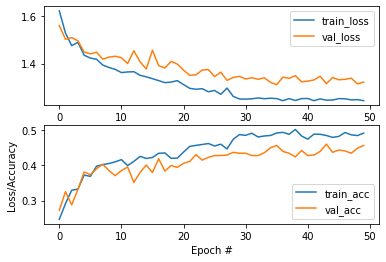

In [ ]:
#Plotting the training and validation loss and accuracy
f,ax=plt.subplots(2,1) 

#Loss
ax[0].plot(np.arange(0, epochs), model_resnet50.history["loss"], label="train_loss")
ax[0].plot(np.arange(0, epochs), model_resnet50.history["val_loss"], label="val_loss")
ax[0].legend()
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
#Accuracy
ax[1].plot(np.arange(0, epochs), model_resnet50.history["accuracy"], label="train_acc")
ax[1].plot(np.arange(0, epochs), model_resnet50.history["val_accuracy"], label="val_acc")
ax[1].legend()
#plt.legend()
#plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")

In [ ]:
#Evaluatin
print("[INFO]: Model godness...")
y_pred = pre_trained_resnet50.predict(x_test, batch_size=128)
y_true=np.argmax(y_test,axis=1)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names = classes_list ))

[INFO]: Model godness...
              precision    recall  f1-score   support

     Dinning       0.69      0.45      0.55       104
     Bedroom       0.46      0.54      0.50       185
  Livingroom       0.50      0.50      0.50       169
     Kitchen       0.44      0.31      0.36       159
    Bathroom       0.36      0.47      0.41       171

    accuracy                           0.46       788
   macro avg       0.49      0.45      0.46       788
weighted avg       0.47      0.46      0.46       788



## VGG19

In [ ]:
#Data Augmentation first
train_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True, zoom_range=.1)
val_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True, zoom_range=.1)
test_generator = ImageDataGenerator(rotation_range=2, horizontal_flip= True, zoom_range=.1)

#Fitting the augmentation defined above to the data
train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(x_test)

In [ ]:
#Defining the VGG Convolutional Neural Net
base_model_vgg = VGG19(include_top = False, weights = 'imagenet', input_shape = (128, 128, 3), classes = y_train.shape[1])
base_model_vgg.summary()

In [ ]:
#freezing_layers(base_model_vgg,'block5_conv1')

In [ ]:
base_model_vgg.trainable = False  
#Adding the final layers to the above base models where the actual classification is done in the dense layers
pre_trained_vgg= Sequential()
pre_trained_vgg.add(base_model_vgg) # adding pre-trained model
pre_trained_vgg.add(Flatten()) 
#Adding the Dense layers along with activation and batch normalization
pre_trained_vgg.add(Dense(1024,activation=('relu'),input_dim=512))
pre_trained_vgg.add(Dense(512,activation=('relu'))) 
pre_trained_vgg.add(Dense(256,activation=('relu'))) 
pre_trained_vgg.add(Dropout(.3))
pre_trained_vgg.add(Dense(128,activation=('relu')))
pre_trained_vgg.add(Dropout(.2))
pre_trained_vgg.add(Dense(5,activation=('softmax'))) 

#Checking the final model summary
pre_trained_vgg.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              8389632   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               3

### analytics india

In [ ]:
#Learning Rate Annealer - decreases the learning rate after a certain number of epochs if the error rate does not change. Here, through this technique, 
# we will monitor the validation accuracy and if it seems to be a plateau in 3 epochs, it will reduce the learning rate by 0.01.
from keras.callbacks import ReduceLROnPlateau

lrr= ReduceLROnPlateau(monitor='accuracy', factor=.01, patience=3, min_lr=1e-5) # "val_acc " warning


In [ ]:
#Initializing the hyperparameters
from tensorflow.keras.optimizers import SGD, Adam
batch_size= 128
epochs=50
learn_rate=.001
sgd=SGD(learning_rate=learn_rate,momentum=.9,nesterov=False)
adam=Adam(learning_rate=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# crossentroty: logaritmic metric from 0.99 (terrible) to 0 (too much perfect)=> https://machinelearningmastery.com/loss-and-loss-functions-for-training-deep-learning-neural-networks/
pre_trained_vgg.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
#Training the model - al usar esta config no tengo un array de val_accuracy, val_loss https://stackoverflow.com/questions/55746382/why-val-loss-and-val-acc-are-not-displaying
vgg19_pre = pre_trained_vgg.fit_generator(
    train_generator.flow(x_train, y_train, batch_size= batch_size),
    epochs = epochs, 
    validation_data = val_generator.flow(x_val, y_val, batch_size = batch_size), 
    steps_per_epoch = len(x_train)//batch_size , # to avoid running out of data error
    validation_steps  = len(x_test)//batch_size, # to avoid running out of data error
    callbacks=[lrr], 
    verbose = 1
    )

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
28/28 [==============================] - 16s 588ms/step - loss: 0.0575 - accuracy: 0.9828 - val_loss: 1.4313 - val_accuracy: 0.6914
Epoch 2/50
28/28 [==============================] - 16s 568ms/step - loss: 0.0591 - accuracy: 0.9822 - val_loss: 1.3357 - val_accuracy: 0.7005
Epoch 3/50
28/28 [==============================] - 16s 575ms/step - loss: 0.0536 - accuracy: 0.9831 - val_loss: 1.3518 - val_accuracy: 0.6888
Epoch 4/50
28/28 [==============================] - 16s 575ms/step - loss: 0.0582 - accuracy: 0.9834 - val_loss: 1.4315 - val_accuracy: 0.6901
Epoch 5/50
28/28 [==============================] - 16s 571ms/step - loss: 0.0464 - accuracy: 0.9859 - val_loss: 1.3313 - val_accuracy: 0.6914
Epoch 6/50
28/28 [==============================] - 16s 580ms/step - loss: 0.0582 - accuracy: 0.9834 - val_loss: 1.3834 - val_accuracy: 0.7018
Epoch 7/50
28/28 [==============================] - 16s 587ms/step - loss: 0.0532 - accuracy: 0.9859 - val_loss: 1.3130 - val_accuracy: 0.6992

In [ ]:
!ls output_folder 

In [ ]:
#save model
pre_trained_vgg.save(output_folder+"deepCNN_vgg19_1.h5")

Text(0, 0.5, 'Loss/Accuracy')

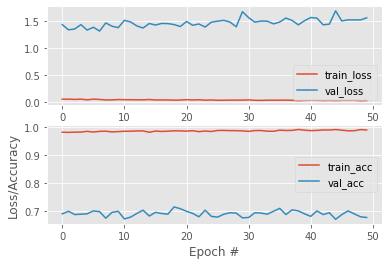

In [ ]:
#Plotting the training and validation loss and accuracy
f,ax=plt.subplots(2,1) 

#Loss
ax[0].plot(np.arange(0, epochs), vgg19_pre.history["loss"], label="train_loss")
ax[0].plot(np.arange(0, epochs), vgg19_pre.history["val_loss"], label="val_loss")
ax[0].legend()
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
#Accuracy
ax[1].plot(np.arange(0, epochs), vgg19_pre.history["accuracy"], label="train_acc")
ax[1].plot(np.arange(0, epochs), vgg19_pre.history["val_accuracy"], label="val_acc")
ax[1].legend()
#plt.legend()
#plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")

In [ ]:
#Evaluatin
print("[INFO]: Model godness...")
y_pred = pre_trained_vgg.predict(x_test, batch_size=128)
y_true=np.argmax(y_test,axis=1)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names = classes_list ))

[INFO]: Model godness...
              precision    recall  f1-score   support

     Dinning       0.76      0.68      0.72        88
     Bedroom       0.76      0.78      0.77       178
  Livingroom       0.64      0.67      0.65       182
     Kitchen       0.62      0.65      0.63       141
    Bathroom       0.60      0.57      0.58       199

    accuracy                           0.66       788
   macro avg       0.67      0.67      0.67       788
weighted avg       0.67      0.66      0.66       788

